Tutorial Author:Mohammadreza Tavasoli Naeini Advisor:Hanrui Wang

This tutorial shows; how to use the TrochQuantum library in building a quantum transformer.
This notebook is adapted, excerpted from https://github.com/rdisipio/qlstm, written by Riccardo Di Sipio. 
In this notebook, we use the TorchQuantum library instead of the Pennylane library to build a quantum machine learning model.

## Build and train a Quantum LSTM.

## Installation

In [1]:
!git clone https://github.com/mit-han-lab/torchquantum.git

fatal: destination path 'torchquantum' already exists and is not an empty directory.


In [2]:
%cd torchquantum

/Users/mohammad/qlstm/torchquantum


In [3]:
!pip install --editable .

Obtaining file:///Users/mohammad/qlstm/torchquantum
  Attempting uninstall: torchquantum
    Found existing installation: torchquantum 0.1.2
    Uninstalling torchquantum-0.1.2:
      Successfully uninstalled torchquantum-0.1.2
  Running setup.py develop for torchquantum


## Setup

Our code requires torchquantum lib,and pytorch. We need torch function from torch.nn.functional, optimizers(optim), torchquantum module.



In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torch.nn as nn
import torchquantum as tq
import torchquantum.functional as tqf

## Build Quantum LSTM 

Before the rise of the transformer, recurrent neural networks, especially Long Short-Term Memory (LSTM), were the most successful techniques for generating and analyzing sequential data. LSTM uses a combination of “memory” and “statefulness” tricks to understand which parts of the input are relevant to compute the output.[1]

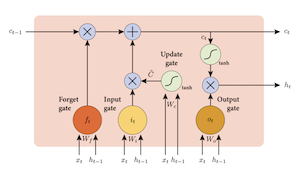<figcaption align = "center"> LSTM architecture </figcaption>

To convert classical LSTM to quantum-enhanced LSTM (QLSTM) each of the classical linear operations Wf, Wi, WC, and Wo is replaced by a hybrid quantum-classical component that consists of a Variational Quantum Circuit sandwiched between classical layers.
[1]

Typically a Quantum Neural Network module consists of three parts: encoder, ansatz, and measurement. We can create an encoder by passing a list of gates to tq.GeneralEncoder. Each entry in the list contains input_idx, func, and wires. Here, each qubit has a rotation-X gate. 4 RX gates in total. They can encode the 4 input data to the quantum state. Then we choose ansatz such that they are entangled between each other, rotated by an arbitrary angle. Finally, we perform Pauli-Z measurements on each qubit by creating a tq.MeasureAll module and passing tq.PauliZ to it. The measure function will return four expectation values from four qubits.



In [2]:
class QLSTM(nn.Module):
    # use 'qiskit.ibmq' instead to run on hardware
    class QLayer_forget(tq.QuantumModule):
        def __init__(self):
            super().__init__()    
            self.n_wires = 4
            self.encoder = tq.GeneralEncoder(
        [   {'input_idx': [0], 'func': 'rx', 'wires': [0]},
            {'input_idx': [1], 'func': 'rx', 'wires': [1]},
            {'input_idx': [2], 'func': 'rx', 'wires': [2]},
            {'input_idx': [3], 'func': 'rx', 'wires': [3]},
        ])
            self.rx0 = tq.RX(has_params=True, trainable=True)
            self.rx1 = tq.RX(has_params=True, trainable=True)
            self.rx2 = tq.RX(has_params=True, trainable=True)
            self.rx3 = tq.RX(has_params=True, trainable=True)
            self.measure = tq.MeasureAll(tq.PauliZ)

        def forward(self, x):
            qdev = tq.QuantumDevice(n_wires=self.n_wires, bsz=x.shape[0], device=x.device)
            self.encoder(qdev, x)
            self.rx0(qdev, wires=0)
            self.rx1(qdev, wires=1)
            self.rx2(qdev, wires=2)
            self.rx3(qdev, wires=3)
            for k in range(self.n_wires):
                if k==self.n_wires-1:
                    tqf.cnot(qdev, wires=[k, 0]) 
                else:
                    tqf.cnot(qdev, wires=[k, k+1])
            return(self.measure(qdev))
        
    class QLayer_input(tq.QuantumModule):
        def __init__(self):
            super().__init__()    
            self.n_wires = 4
            self.encoder = tq.GeneralEncoder(
        [   {'input_idx': [0], 'func': 'rx', 'wires': [0]},
            {'input_idx': [1], 'func': 'rx', 'wires': [1]},
            {'input_idx': [2], 'func': 'rx', 'wires': [2]},
            {'input_idx': [3], 'func': 'rx', 'wires': [3]},
        ])
            self.rx0 = tq.RX(has_params=True, trainable=True)
            self.rx1 = tq.RX(has_params=True, trainable=True)
            self.rx2 = tq.RX(has_params=True, trainable=True)
            self.rx3 = tq.RX(has_params=True, trainable=True)
            self.measure = tq.MeasureAll(tq.PauliZ)

        def forward(self, x):
            qdev = tq.QuantumDevice(n_wires=self.n_wires, bsz=x.shape[0], device=x.device)
            self.encoder(qdev, x)
            self.rx0(qdev, wires=0)
            self.rx1(qdev, wires=1)
            self.rx2(qdev, wires=2)
            self.rx3(qdev, wires=3)
            for k in range(self.n_wires):
                if k==self.n_wires-1:
                    tqf.cnot(qdev, wires=[k, 0]) 
                else:
                    tqf.cnot(qdev, wires=[k, k+1])
            return(self.measure(qdev))
        
    class QLayer_update(tq.QuantumModule):
        def __init__(self):
            super().__init__()    
            self.n_wires = 4
            self.encoder = tq.GeneralEncoder(
        [   {'input_idx': [0], 'func': 'rx', 'wires': [0]},
            {'input_idx': [1], 'func': 'rx', 'wires': [1]},
            {'input_idx': [2], 'func': 'rx', 'wires': [2]},
            {'input_idx': [3], 'func': 'rx', 'wires': [3]},
        ])
            self.rx0 = tq.RX(has_params=True, trainable=True)
            self.rx1 = tq.RX(has_params=True, trainable=True)
            self.rx2 = tq.RX(has_params=True, trainable=True)
            self.rx3 = tq.RX(has_params=True, trainable=True)
            self.measure = tq.MeasureAll(tq.PauliZ)

        def forward(self, x):
            qdev = tq.QuantumDevice(n_wires=self.n_wires, bsz=x.shape[0], device=x.device)
            self.encoder(qdev, x)
            self.rx0(qdev, wires=0)
            self.rx1(qdev, wires=1)
            self.rx2(qdev, wires=2)
            self.rx3(qdev, wires=3)
            for k in range(self.n_wires):
                if k==self.n_wires-1:
                    tqf.cnot(qdev, wires=[k, 0]) 
                else:
                    tqf.cnot(qdev, wires=[k, k+1])
            return(self.measure(qdev))
        
    class QLayer_output(tq.QuantumModule):
        def __init__(self):
            super().__init__()    
            self.n_wires = 4
            self.encoder = tq.GeneralEncoder(
        [   {'input_idx': [0], 'func': 'rx', 'wires': [0]},
            {'input_idx': [1], 'func': 'rx', 'wires': [1]},
            {'input_idx': [2], 'func': 'rx', 'wires': [2]},
            {'input_idx': [3], 'func': 'rx', 'wires': [3]},
        ])
            self.rx0 = tq.RX(has_params=True, trainable=True)
            self.rx1 = tq.RX(has_params=True, trainable=True)
            self.rx2 = tq.RX(has_params=True, trainable=True)
            self.rx3 = tq.RX(has_params=True, trainable=True)
            self.measure = tq.MeasureAll(tq.PauliZ)

        def forward(self, x):
            qdev = tq.QuantumDevice(n_wires=self.n_wires, bsz=x.shape[0], device=x.device)
            self.encoder(qdev, x)
            self.rx0(qdev, wires=0)
            self.rx1(qdev, wires=1)
            self.rx2(qdev, wires=2)
            self.rx3(qdev, wires=3)
            for k in range(self.n_wires):
                if k==self.n_wires-1:
                    tqf.cnot(qdev, wires=[k, 0]) 
                else:
                    tqf.cnot(qdev, wires=[k, k+1])
            return(self.measure(qdev))
        
    def __init__(self, 
                input_size, 
                hidden_size, 
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False, 
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget':self.QLayer_forget(),
            'input': self.QLayer_input(),
            'update':self.QLayer_update(),
            'output':self.QLayer_output()
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]
            
            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)



## POS_tagging

Here we define the possible tags: determinant, noun, verb.

In [3]:
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}  # Assign each tag with a unique index
ix_to_tag = {i:k for k,i in tag_to_ix.items()}

The function below tokenizes the sentence and matches the label to each word.

In [4]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

Now we can prepare the input dataset.

In [5]:
training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}

# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index

print(f"Vocabulary: {word_to_ix}")
print(f"Entities: {ix_to_tag}")

Vocabulary: {'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}
Entities: {0: 'DET', 1: 'NN', 2: 'V'}


The idea is to pass the two sequences through the LSTM, which will output the hidden array of vectors [h_0, h_1, h_2, h_3, h_4], one for each word. A dense layer “head” is attached to the LSTM’s outputs to calculate the probability that each word may be a determinant, noun or verb.

In [6]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, n_qubits=0):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        if n_qubits > 0:
            print("Tagger will use Quantum LSTM")
            self.lstm = QLSTM(embedding_dim, hidden_dim, n_qubits=n_qubits)
        else:
            print("Tagger will use Classical LSTM")
            self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_logits = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_logits, dim=1)
        return tag_scores

In [7]:
embedding_dim = 8
hidden_dim = 6
n_epochs = 300

In [8]:
model_classical = LSTMTagger(embedding_dim, 
                        hidden_dim, 
                        vocab_size=len(word_to_ix), 
                        tagset_size=len(tag_to_ix), 
                        n_qubits=0)

Tagger will use Classical LSTM


## Training

Following the example from the PyTorch website, we train the two networks (classical and quantum LSTM) for 300 epochs. 

In [9]:
def train(model, n_epochs, training_data, word_to_ix, tag_to_ix):
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    history = {
        'loss': [],
        'acc': []
    }
    for epoch in range(n_epochs):
        losses = []
        preds = []
        targets = []
        for sentence, tags in training_data:
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            sentence_in = prepare_sequence(sentence, word_to_ix)
            labels = prepare_sequence(tags, tag_to_ix)

            # Step 3. Run our forward pass.
            tag_scores = model(sentence_in)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(tag_scores, labels)
            loss.backward()
            optimizer.step()
            losses.append(float(loss))
            
            probs = torch.softmax(tag_scores, dim=-1)
            preds.append(probs.argmax(dim=-1))
            targets.append(labels)

        avg_loss = np.mean(losses)
        history['loss'].append(avg_loss)
        
        preds = torch.cat(preds)
        targets = torch.cat(targets)
        corrects = (preds == targets)
        accuracy = corrects.sum().float() / float(targets.size(0) )
        history['acc'].append(accuracy)

        print(f"Epoch {epoch+1} / {n_epochs}: Loss = {avg_loss:.3f} Acc = {accuracy:.2f}")

    return history

In [10]:
history_classical = train(model_classical, n_epochs, training_data, word_to_ix, tag_to_ix)

Epoch 1 / 300: Loss = 1.116 Acc = 0.22
Epoch 2 / 300: Loss = 1.102 Acc = 0.22
Epoch 3 / 300: Loss = 1.089 Acc = 0.56
Epoch 4 / 300: Loss = 1.078 Acc = 0.67
Epoch 5 / 300: Loss = 1.068 Acc = 0.56
Epoch 6 / 300: Loss = 1.058 Acc = 0.67
Epoch 7 / 300: Loss = 1.049 Acc = 0.56
Epoch 8 / 300: Loss = 1.041 Acc = 0.67
Epoch 9 / 300: Loss = 1.034 Acc = 0.67
Epoch 10 / 300: Loss = 1.027 Acc = 0.67
Epoch 11 / 300: Loss = 1.020 Acc = 0.67
Epoch 12 / 300: Loss = 1.013 Acc = 0.67
Epoch 13 / 300: Loss = 1.007 Acc = 0.56
Epoch 14 / 300: Loss = 1.001 Acc = 0.56
Epoch 15 / 300: Loss = 0.995 Acc = 0.44
Epoch 16 / 300: Loss = 0.989 Acc = 0.44
Epoch 17 / 300: Loss = 0.984 Acc = 0.44
Epoch 18 / 300: Loss = 0.978 Acc = 0.56
Epoch 19 / 300: Loss = 0.973 Acc = 0.56
Epoch 20 / 300: Loss = 0.967 Acc = 0.56
Epoch 21 / 300: Loss = 0.961 Acc = 0.56
Epoch 22 / 300: Loss = 0.956 Acc = 0.56
Epoch 23 / 300: Loss = 0.950 Acc = 0.56
Epoch 24 / 300: Loss = 0.944 Acc = 0.67
Epoch 25 / 300: Loss = 0.939 Acc = 0.67
Epoch 26 

In [11]:
def print_result(model, training_data, word_to_ix, ix_to_tag):
    with torch.no_grad():
        input_sentence = training_data[0][0]
        labels = training_data[0][1]
        inputs = prepare_sequence(input_sentence, word_to_ix)
        tag_scores = model(inputs)

        tag_ids = torch.argmax(tag_scores, dim=1).numpy()
        tag_labels = [ix_to_tag[k] for k in tag_ids]
        print(f"Sentence:  {input_sentence}")
        print(f"Labels:    {labels}")
        print(f"Predicted: {tag_labels}")

In [12]:
print_result(model_classical, training_data, word_to_ix, ix_to_tag)

Sentence:  ['The', 'dog', 'ate', 'the', 'apple']
Labels:    ['DET', 'NN', 'V', 'DET', 'NN']
Predicted: ['DET', 'NN', 'V', 'DET', 'NN']


In [13]:
n_qubits = 4

model_quantum = LSTMTagger(embedding_dim, 
                        hidden_dim, 
                        vocab_size=len(word_to_ix), 
                        tagset_size=len(tag_to_ix), 
                        n_qubits=n_qubits)

Tagger will use Quantum LSTM


In [16]:
history_quantum = train(model_quantum, n_epochs, training_data, word_to_ix, tag_to_ix)

Epoch 1 / 300: Loss = 0.431 Acc = 0.78
Epoch 2 / 300: Loss = 0.430 Acc = 0.78
Epoch 3 / 300: Loss = 0.428 Acc = 0.78
Epoch 4 / 300: Loss = 0.427 Acc = 0.78
Epoch 5 / 300: Loss = 0.425 Acc = 0.78
Epoch 6 / 300: Loss = 0.423 Acc = 0.78
Epoch 7 / 300: Loss = 0.421 Acc = 0.78
Epoch 8 / 300: Loss = 0.420 Acc = 0.78
Epoch 9 / 300: Loss = 0.418 Acc = 0.78
Epoch 10 / 300: Loss = 0.416 Acc = 0.78
Epoch 11 / 300: Loss = 0.414 Acc = 0.78
Epoch 12 / 300: Loss = 0.412 Acc = 0.78
Epoch 13 / 300: Loss = 0.410 Acc = 0.78
Epoch 14 / 300: Loss = 0.408 Acc = 0.78
Epoch 15 / 300: Loss = 0.406 Acc = 0.78
Epoch 16 / 300: Loss = 0.404 Acc = 0.78
Epoch 17 / 300: Loss = 0.401 Acc = 0.78
Epoch 18 / 300: Loss = 0.399 Acc = 0.78
Epoch 19 / 300: Loss = 0.397 Acc = 0.78
Epoch 20 / 300: Loss = 0.394 Acc = 0.78
Epoch 21 / 300: Loss = 0.392 Acc = 0.78
Epoch 22 / 300: Loss = 0.389 Acc = 0.78
Epoch 23 / 300: Loss = 0.387 Acc = 0.78
Epoch 24 / 300: Loss = 0.384 Acc = 0.78
Epoch 25 / 300: Loss = 0.381 Acc = 0.78
Epoch 26 

In [17]:
print_result(model_quantum, training_data, word_to_ix, ix_to_tag)

Sentence:  ['The', 'dog', 'ate', 'the', 'apple']
Labels:    ['DET', 'NN', 'V', 'DET', 'NN']
Predicted: ['DET', 'NN', 'V', 'DET', 'NN']


### Plot the training history

In [20]:
from matplotlib import pyplot as plt

def plot_history(history_classical, history_quantum):
    loss_c = history_classical['loss']
    acc_c = history_classical['acc']
    loss_q = history_quantum['loss']
    acc_q = history_quantum['acc']
    n_epochs = max([len(loss_c), len(loss_q)])
    x_epochs = [i for i in range(n_epochs)]
    
    fig, ax1 = plt.subplots()
    
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(loss_c, label="Classical LSTM loss", color='orange', linestyle='dashed')
    ax1.plot(loss_q, label="Quantum LSTM loss", color='red', linestyle='solid')

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy")
    ax2.plot(acc_c, label="Classical LSTM accuracy", color='steelblue', linestyle='dashed')
    ax2.plot(acc_q, label="Quantum LSTM accuracy", color='blue', linestyle='solid')

    plt.title("Part-of-Speech Tagger Training__torch")
    plt.ylim(0., 1.1)
    #plt.legend(loc="upper right")
    fig.legend(loc="upper right", bbox_to_anchor=(1,0.8), bbox_transform=ax1.transAxes)

    plt.savefig("pos_training_torch.pdf")
    plt.savefig("pos_training_torch.png")
    
    plt.show()

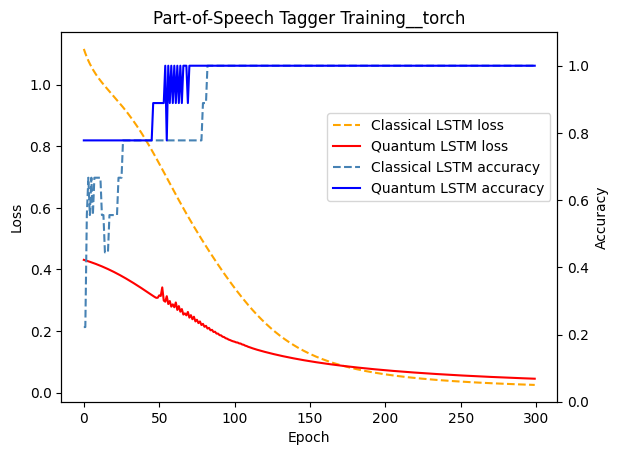

In [21]:
%matplotlib inline
plot_history(history_classical, history_quantum)

The loss function decreases as a function of the training epoch, and after 300 epochs both networks are able to tag correctly the first sentence. Due to the complexity of the simulation of the quantum circuit, it took approximatively 15 minutes to finish the training, to be compared to a mere 8 seconds for the classical case. 

## Refrences

[1] Riccardo Di Sipio, Jia-Hong Huang, Samuel Yen-
Chi Chen, Stefano Mangini, and Marcel Worring.
The dawn of quantum natural language processing.
In ICASSP 2022-2022 IEEE International Confer-
ence on Acoustics, Speech and Signal Processing
(ICASSP), pages 8612–8616. IEEE, 2022.